In [58]:
import sys
sys.path.append('../..')
import wandb
from data import load_data_strasb
from model_configs import build_model
from sklearn.linear_model import RidgeClassifier
from meco import MECO
from models import GCN, train_lens, test_lens
import os
import joblib
from scipy.io import arff
import pandas as pd
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
import torch
import torch_explain as te
from torch.nn.functional import one_hot
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, Sequential
from torch_geometric.utils.convert import from_networkx
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from torch_geometric.utils import to_undirected, add_remaining_self_loops
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import networkx as nx
from torch.nn.functional import one_hot, leaky_relu
from sklearn.feature_selection import RFECV

In [47]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
plt.rc('font', **font)

In [3]:
models = ['GCN']
# models = ['GCN', 'DT']

# load data
x, y, is_control, fnames, cnames = load_data_strasb(data_path='../../data/strasb/')

10

In [59]:
skb = SelectKBest(k=500)
rfe = RFECV(RandomForestClassifier(random_state=42), step=1, cv=3, min_features_to_select=1, n_jobs=3)
x1 = skb.fit_transform(x, y)
x2 = rfe.fit_transform(x1, y)

In [60]:
joblib.dump(skb, os.path.join('./stras-artifacts', f'skb.joblib'))
joblib.dump(rfe, os.path.join('./stras-artifacts', f'rfe.joblib'))

['./stras-artifacts\\rfe.joblib']

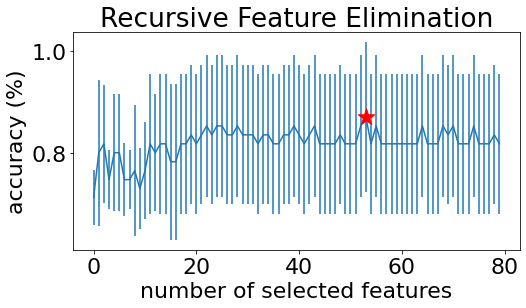

In [64]:
skb = joblib.load(os.path.join('./stras-artifacts', f'skb.joblib'))
rfe = joblib.load(os.path.join('./stras-artifacts', f'rfe.joblib'))
mscore, sscore = rfe.cv_results_['mean_test_score'], rfe.cv_results_['std_test_score']
nfeatures = np.arange(len(mscore))

result_dir = './stras-results/figs_base'
os.makedirs(result_dir, exist_ok=True)

maxf = 80
plt.figure(figsize=[8, 4])
plt.errorbar(nfeatures[:maxf], mscore[:maxf], yerr=sscore[:maxf])
bestf = np.argmax(mscore[:maxf])
plt.scatter([bestf], mscore[:maxf][bestf], marker='*', s=300, c='r', zorder=100)
# plt.ylim([0.5, 0.8])
plt.title('Recursive Feature Elimination')
plt.ylabel('accuracy (%)')
plt.xlabel('number of selected features')
plt.savefig(os.path.join(result_dir, 'rfe.png'))
plt.savefig(os.path.join(result_dir, 'rfe.pdf'))
plt.show()

In [73]:
rfe.support_.shape

(500,)

In [74]:
skb.get_support().shape

(40895,)

In [77]:
fnames_skb = fnames[skb.get_support()]
fnames_rfe = fnames_skb[rfe.support_]
fnames_rfe

Index(['ENSMUSG00000022951', 'ENSMUSG00000022957', 'ENSMUSG00000022960',
       'ENSMUSG00000022961', 'ENSMUSG00000022962', 'ENSMUSG00000022964',
       'ENSMUSG00000022965', 'ENSMUSG00000022967', 'ENSMUSG00000022969',
       'ENSMUSG00000022971', 'ENSMUSG00000022973', 'ENSMUSG00000022978',
       'ENSMUSG00000022982', 'ENSMUSG00000022983', 'ENSMUSG00000023935',
       'ENSMUSG00000024039', 'ENSMUSG00000024210', 'ENSMUSG00000024778',
       'ENSMUSG00000025613', 'ENSMUSG00000025854', 'ENSMUSG00000026048',
       'ENSMUSG00000028334', 'ENSMUSG00000028364', 'ENSMUSG00000028698',
       'ENSMUSG00000031302', 'ENSMUSG00000031594', 'ENSMUSG00000031610',
       'ENSMUSG00000040785', 'ENSMUSG00000040820', 'ENSMUSG00000042962',
       'ENSMUSG00000044626', 'ENSMUSG00000045975', 'ENSMUSG00000047412',
       'ENSMUSG00000048406', 'ENSMUSG00000050953', 'ENSMUSG00000051396',
       'ENSMUSG00000052125', 'ENSMUSG00000052299', 'ENSMUSG00000052957',
       'ENSMUSG00000053062', 'ENSMUSG00000053414', 

In [109]:
pd.Series(fnames_rfe).to_csv(os.path.join(result_dir, 'best_features.csv'))

In [81]:
train_index = test_index = np.arange(len(x2))
xtorch = torch.FloatTensor(x2)
model = train_lens(xtorch, y, [], train_index, 0.7)

Epoch 0: 0.6906304359436035
Epoch 500: 0.01280996948480606
Epoch 1000: 0.003182475222274661
Epoch 1500: 0.001399303087964654
Epoch 2000: 0.000763585208915174
Epoch 2500: 0.0004589246236719191
Epoch 3000: 0.00030599263845942914
Epoch 3500: 0.00020572195353452116
Epoch 4000: 0.00014806273975409567
Epoch 4500: 0.00010661588748916984
Epoch 5000: 7.80978225520812e-05
Epoch 5500: 5.8234269090462476e-05
Epoch 6000: 4.301944136386737e-05
Epoch 6500: 3.304393612779677e-05
Epoch 7000: 2.4657832909724675e-05
Epoch 7500: 1.8825698134605773e-05
Epoch 8000: 1.4117303180682939e-05
Epoch 8500: 1.0817963811859954e-05
Epoch 9000: 8.182704732462298e-06
Epoch 9500: 6.303092959569767e-06
Epoch 10000: 4.86410590383457e-06


In [83]:
print(model.lens.alpha_norm.median(dim=0)[0].detach().numpy())
print(model.lens.alpha_norm.max(dim=0)[0].detach().numpy())
print(model.lens.alpha_norm.min(dim=0)[0].detach().numpy())
explanations = test_lens(model, xtorch, y, [], train_index, test_index, fnames_rfe, cnames)
explanations

[0.02450794 0.9007007  0.01028289 0.36940646 0.02507183 0.965781
 0.9642247  0.9913884  0.5343197  0.01932873 0.96760774 0.01779258
 0.9563923  0.9711758  0.97002757 0.02264174 0.9637063  0.9818406
 0.9862565  0.00654112 0.01279324 0.9577654  0.9854056  0.9821173
 0.9856759  0.01007391 0.96609384 0.9803497  0.9663467  0.9641727
 0.95179135 0.01515048 0.9874833  0.8417503  0.9209506  0.9632096
 0.98894364 0.99175197 0.9751364  0.99842525 0.99024266 0.99700993
 0.00959369 0.0058304  0.9774874  0.9806287  0.9758122  0.9725985
 0.01855704 0.01845123 0.01029505 0.9607766  0.21219623 0.03159397]
[0.02932938 0.9757414  0.07165201 0.6383803  0.9367873  0.9684506
 0.9879524  0.9941885  0.9773964  0.96812606 0.987021   0.9452779
 0.9891044  0.9862998  0.97365695 0.02386062 0.97538465 0.99574995
 0.99248147 0.01417193 0.01290352 0.98407674 0.994336   0.9939222
 0.9939235  0.01452716 0.99094695 0.99206746 0.9857779  0.9793236
 0.9660762  0.05466295 0.9932991  0.99203724 0.9845035  0.9674896
 1.   

{'0': {'explanation': 'ENSMUSG00000053062 & ~ENSMUSG00000028364 & ~ENSMUSG00000048406',
  'name': 'mem=1',
  'explanation_accuracy': 0.8214285714285714,
  'explanation_complexity': 3},
 '1': {'explanation': '~ENSMUSG00000024778 | ~ENSMUSG00000053062 | ~ENSMUSG00000053414',
  'name': 'mem=1',
  'explanation_accuracy': 0.9642857142857143,
  'explanation_complexity': 3},
 'accuracy': 1.0,
 'f1': 1.0}

In [106]:
cols = ['Formula', 'Coverage']
explanations_fmt = pd.DataFrame(columns=cols)
for yid, res in explanations.items():
    if yid in ['accuracy', 'f1']: continue
    formula = res['explanation'].replace(' &', ') AND').replace(' |', ') OR')
    formula = formula.replace('~ENSMUSG', 'underExpressed(ENSMUSG').replace(' ENSMUSG', 'overExpressed(ENSMUSG')
    if formula.startswith('ENSMUSG'):
        formula = 'overExpressed(' + formula
    
    formula += ')'
    formula = 'class=' + str(yid) + ' <- ' + formula
    fm_df = pd.DataFrame([[formula, res['explanation_accuracy']]], columns=cols)
    explanations_fmt = pd.concat((explanations_fmt, fm_df))

explanations_fmt.reset_index(inplace=True, drop=True)

In [107]:
explanations_fmt.to_csv(os.path.join(result_dir, 'explanations.csv'))
explanations_fmt

,Formula,Coverage
0,class=0 <- overExpressed(ENSMUSG00000053062) A...,0.821429
1,class=1 <- underExpressed(ENSMUSG00000024778) ...,0.964286
